# LQR

In this example, we show that a convex optimization layer can recover a solution to the linear quadratic regulator (LQR) control problem.

In [1]:
import cvxpy as cp
import numpy as np
import tensorflow as tf
from cvxpylayers.tensorflow import CvxpyLayer

from scipy.linalg import sqrtm
from scipy.linalg import solve_discrete_are

In [2]:
np.random.seed(0)

# generate problem data
n, m = 4, 2
noise = np.sqrt(0.25)
Q0 = np.eye(n)
R0 = np.eye(m)
A = np.random.randn(n, n)
A /= np.max(np.abs(np.linalg.eig(A)[0]))
B = np.random.randn(n, m)
W = noise**2 * np.eye(n)

In [3]:
# compute lqr solution
P = cp.Variable((n, n), PSD=True)
R0cvxpy = cp.Parameter((m, m), PSD=True)

objective = cp.trace(P@W)
constraints = [
    cp.bmat([[R0cvxpy + B.T@P@B, B.T@P@A],
             [A.T@P@B, Q0 + A.T@P@A - P]]) >> 0,
    P >> 0]
R0cvxpy.value = R0
result = cp.Problem(cp.Maximize(objective), constraints).solve()
P_lqr = P.value
print(result)

1.8031165790342367


In [4]:
P_lqr

array([[1.85426156, 0.12235637, 0.51550081, 1.05324043],
       [0.12235637, 1.18209044, 0.09639788, 0.44752023],
       [0.51550081, 0.09639788, 1.31473547, 0.6759572 ],
       [1.05324043, 0.44752023, 0.6759572 , 2.86137885]])

In [5]:
# set up policy
x = cp.Parameter((n, 1))
P_sqrt = cp.Parameter((n, n))

u = cp.Variable((m, 1))
xnext = cp.Variable((n, 1))

objective = cp.quad_form(u, R0) + cp.sum_squares(P_sqrt @ xnext)
constraints = [xnext == A @ x + B @ u]
prob = cp.Problem(cp.Minimize(objective), constraints)
policy = CvxpyLayer(prob, [x, P_sqrt], [u])

In [6]:
# initialize parameters
Qt, Rt, At, Bt = [tf.constant(t, dtype=tf.float64) for t in [Q0, R0, A, B]]
P_sqrt = tf.Variable(tf.eye(n, dtype=tf.float64))

In [7]:
def repeat(tensor, batch_size):
    return tf.tile(tf.reshape(tensor, (1,) + tensor.shape),
                   tf.constant([batch_size] + [1 for _ in tensor.shape]))

In [8]:
def loss(time_horizon, batch_size, P_sqrt, seed=None):
    
    if seed is not None:
        tf.random.set_seed(seed)
        
    x_batch = tf.random.normal((batch_size, n, 1), dtype=tf.float64)
    P_sqrt_batch = repeat(P_sqrt, batch_size)
    Qt_batch = repeat(Qt, batch_size)
    Rt_batch = repeat(Rt, batch_size)
    At_batch = repeat(At, batch_size)
    Bt_batch = repeat(Bt, batch_size)
    
    loss = 0.0
    for _ in range(time_horizon):
        u_batch, = policy(x_batch, P_sqrt_batch)
        state_cost = tf.matmul(tf.transpose(tf.matmul(Qt_batch, x_batch), (0, 2, 1)),
                               x_batch)
        control_cost = tf.matmul(tf.transpose(tf.matmul(Rt_batch, u_batch), (0, 2, 1)),
                                 u_batch)
        cost_batch = tf.squeeze(state_cost) + tf.squeeze(control_cost)
        loss += tf.math.reduce_sum(cost_batch) / (time_horizon * batch_size)
        x_batch = tf.matmul(At_batch, x_batch) + \
            tf.matmul(Bt_batch, u_batch) + \
            noise * tf.random.normal((batch_size, n, 1), dtype=tf.float64)
    return loss

In [9]:
Kt = np.linalg.solve(R0 + B.T @ P_lqr @ B, -B.T @ P_lqr @ A)
loss_lqr = loss(100, 6, tf.constant(sqrtm(P_lqr)), seed=0)

In [10]:
losses = []
opt = tf.keras.optimizers.SGD(learning_rate=0.5)
test_loss = None
for k in range(50):
    test_loss = float(loss(100, 6, P_sqrt, seed=0))
    K_np = tf.linalg.solve(Rt + tf.transpose(Bt) @ tf.transpose(P_sqrt) @ P_sqrt @ Bt,
                           -tf.transpose(Bt) @ tf.transpose(P_sqrt) @ P_sqrt @ At).numpy()
    dist = np.linalg.norm(K_np - Kt)
    P = (tf.transpose(P_sqrt) @ P_sqrt).numpy()
    dist_P = np.linalg.norm(P_lqr - P)
    losses.append(test_loss)
    print("it: %03d, loss: %3.3f, dist: %3.3f, dist_P: %3.3f" % (k+1, test_loss - loss_lqr, dist, dist_P))
    
    with tf.GradientTape() as tape:
        l = loss(100, 6, P_sqrt, seed=k+1)
    grad, = tape.gradient(l, [P_sqrt])
    opt.apply_gradients([(grad, P_sqrt)])
    if k == 25:
        opt = tf.keras.optimizers.SGD(learning_rate=0.1)

it: 001, loss: 0.284, dist: 0.291, dist_P: 2.905
it: 002, loss: 0.199, dist: 0.184, dist_P: 2.771
it: 003, loss: 0.093, dist: 0.127, dist_P: 2.746
it: 004, loss: 0.056, dist: 0.100, dist_P: 2.745
it: 005, loss: 0.031, dist: 0.066, dist_P: 2.754
it: 006, loss: 0.022, dist: 0.055, dist_P: 2.758
it: 007, loss: 0.015, dist: 0.045, dist_P: 2.775
it: 008, loss: 0.010, dist: 0.039, dist_P: 2.793
it: 009, loss: 0.008, dist: 0.037, dist_P: 2.794
it: 010, loss: 0.007, dist: 0.035, dist_P: 2.788
it: 011, loss: 0.007, dist: 0.038, dist_P: 2.799
it: 012, loss: 0.006, dist: 0.031, dist_P: 2.768
it: 013, loss: 0.005, dist: 0.039, dist_P: 2.788
it: 014, loss: 0.005, dist: 0.053, dist_P: 2.822
it: 015, loss: 0.004, dist: 0.048, dist_P: 2.802
it: 016, loss: 0.004, dist: 0.023, dist_P: 2.730
it: 017, loss: 0.005, dist: 0.021, dist_P: 2.708
it: 018, loss: 0.004, dist: 0.018, dist_P: 2.704
it: 019, loss: 0.003, dist: 0.031, dist_P: 2.743
it: 020, loss: 0.003, dist: 0.044, dist_P: 2.775
it: 021, loss: 0.003

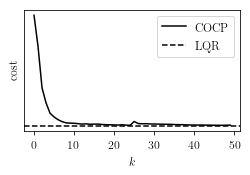

In [12]:
import matplotlib.pyplot as plt
from utils import latexify
import matplotlib

latexify(fig_width=4)
fig, ax = plt.subplots()
plt.xticks([0, 10, 20, 30, 40, 50])
plt.semilogy(losses, color='k', label='COCP')
plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.axhline(float(loss_lqr), linestyle='--', color='k', label='LQR')
plt.legend()
plt.ylabel("cost")
plt.xlabel("$k$")
plt.subplots_adjust(left=.15, bottom=.2)
plt.savefig("lqr.pdf")
plt.show()